In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from linear_models import ftr_transform, max_ftr_transform

# load results

In [2]:
wave = "sym5"
dirs = [wave + "_saliency_warmstart_seed=1"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave=wave, mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [3]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)

index2o = {}
index2t = {}
num = 0
for i, _ in enumerate(lamL1wave_grid):
    for j, _ in enumerate(lamL1attr_grid):
        loc = (lamL1wave == lamL1wave_grid[i]) & (lamL1attr == lamL1attr_grid[j])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            index2o[(i,j)] = loc
            index2t[num] = (i,j)
        num += 1
            
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)
psi_list = []
wt_list = []
for r in range(R):
    for c in range(C):
        wt = mos[index2o[(r,c)]]
        wt_list.append(wt)
        phi, psi, x = get_wavefun(wt)
        psi_list.append(psi)            

# calculate accuracy

In [4]:
reg = []
log = []
for use_reg in [True, False]:
    (train_loader, test_loader) = get_dataloader(p.data_path, 
                                                 batch_size=p.batch_size,
                                                 is_continuous=use_reg)   
    for i,wt in enumerate(wt_list):
        wt = wt.to('cpu')
        (X, y), (X_test, y_test) = ftr_transform(wt, train_loader, test_loader)
        
        if use_reg:
            clf = LinearRegression()
            scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
            reg.append(scores.mean())
        else:
            clf = LogisticRegression()
            scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
            log.append(scores.mean())
        print('\r {}'.format(i), end='')
reg = np.array(reg)
log = np.array(log)

 104

wavelet with best regression performance

Hyperparameter: lamL1wave=0.000270 lamL1attr=10.000000
Error: Recon=0.029551
Sparsity: Wave=4.146033
Interp: Saliency=0.355251 InputXGrade=0.279293
Wavelet loss: lSum=0.000018 hsum=0.000449 L2norm=0.000130 CMF=0.004618 Conv=0.000232


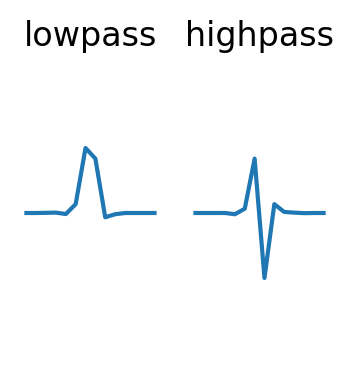

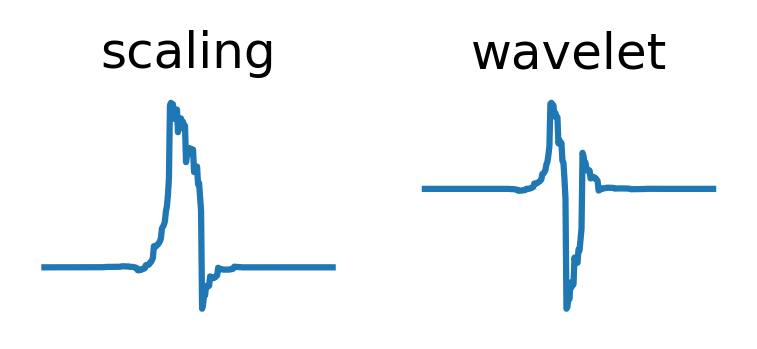

In [5]:
idx1, idx2 = index2t[np.argmax(reg).flatten()[0]]
wt = mos[index2o[(idx1, idx2)]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index2o[(idx1, idx2)]], res['lamL1attr'][index2o[(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index2o[(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][index2o[(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][index2o[(idx1, idx2)]], res['L1inputxgrad_loss'][index2o[(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['hsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['L2norm_loss'][index2o[(idx1, idx2)]],
                                                                                          res['CMF_loss'][index2o[(idx1, idx2)]],
                                                                                          res['conv_loss'][index2o[(idx1, idx2)]]))


plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

In [6]:
wt = mos[index2o[(idx1, idx2)]]
wt_o = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
model = load_pretrained_model(p.model_path, device=device)    

r = {
    'Standard Wavelet (Sym5)': [],
    'AWD (Ours)': [],    
    'LSTM': [],
}

for use_reg in [True]:
    (train_loader, test_loader) = get_dataloader(p.data_path, 
                                 batch_size=p.batch_size,
                                 is_continuous=use_reg)   


    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = ftr_transform(wt, train_loader, test_loader)
    
    clf = LinearRegression().fit(X, y)
    preds = clf.predict(X_test)
    error = metrics.r2_score(y_test, preds)
    r['AWD (Ours)'].append(error)

    wt_o = wt_o.to('cpu')
    (X, y), (X_test, y_test) = ftr_transform(wt_o, train_loader, test_loader)

    clf_o = LinearRegression().fit(X, y)
    preds = clf_o.predict(X_test)
    error = metrics.r2_score(y_test, preds)
    r['Standard Wavelet (Sym5)'].append(error)

    preds = []
    y_test = []
    for data, labels in test_loader:   
        preds.append(model(data).detach().numpy())
        y_test.append(labels.detach().numpy())
    preds = np.vstack(preds)
    y_test = np.vstack(y_test)
    error = metrics.r2_score(y_test, preds)
    r['LSTM'].append(error)
scores = pd.DataFrame.from_dict(r).round(3)
scores.index = ['Regression (R2 score)']

In [7]:
print(scores.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Standard Wavelet (Sym5) &  AWD (Ours) &   LSTM \\
\midrule
Regression (R2 score) &                    0.243 &       0.247 &  0.237 \\
\bottomrule
\end{tabular}



wavelet with best classification performance

Hyperparameter: lamL1wave=0.000710 lamL1attr=0.483290
Error: Recon=0.000255
Sparsity: Wave=4.083083
Interp: Saliency=0.361365 InputXGrade=0.288160
Wavelet loss: lSum=0.000000 hsum=0.000123 L2norm=0.000001 CMF=0.000025 Conv=0.000001


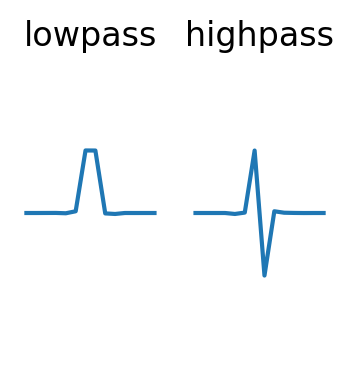

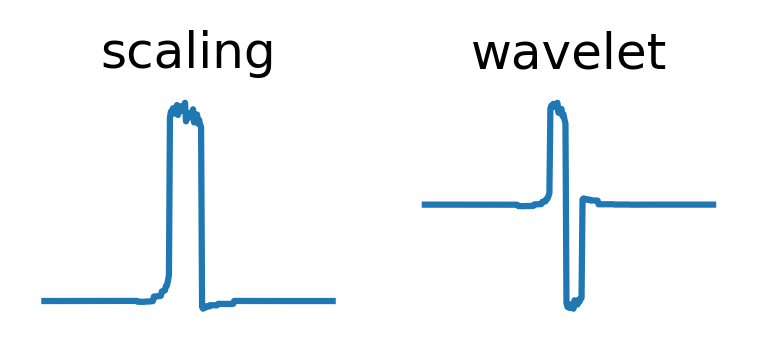

In [8]:
idx1, idx2 = index2t[np.argmax(log).flatten()[0]]
wt = mos[index2o[(idx1, idx2)]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index2o[(idx1, idx2)]], res['lamL1attr'][index2o[(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index2o[(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][index2o[(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][index2o[(idx1, idx2)]], res['L1inputxgrad_loss'][index2o[(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['hsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['L2norm_loss'][index2o[(idx1, idx2)]],
                                                                                          res['CMF_loss'][index2o[(idx1, idx2)]],
                                                                                          res['conv_loss'][index2o[(idx1, idx2)]]))


plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

In [9]:
wt = mos[index2o[(idx1, idx2)]]
wt_o = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
model = load_pretrained_model(p.model_path, device=device)    

r = {
    'Standard Wavelet (Sym5)': [],
    'AWD (Ours)': [],    
    'LSTM': [],
}

for use_reg in [False]:
    (train_loader, test_loader) = get_dataloader(p.data_path, 
                                 batch_size=p.batch_size,
                                 is_continuous=use_reg)   


    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = ftr_transform(wt, train_loader, test_loader)

    clf = LogisticRegression().fit(X, y)
    preds = clf.predict(X_test)
    preds = 1 * (preds > 0)
    error = metrics.accuracy_score(y_test, preds)
    r['AWD (Ours)'].append(error)

    wt_o = wt_o.to('cpu')
    (X, y), (X_test, y_test) = ftr_transform(wt_o, train_loader, test_loader)
    clf_o = LogisticRegression().fit(X, y)
    preds = clf_o.predict(X_test)
    preds = 1 * (preds > 0)
    error = metrics.accuracy_score(y_test, preds)
    r['Standard Wavelet (Sym5)'].append(error)

    preds = []
    y_test = []
    for data, labels in test_loader:   
        preds.append(model(data).detach().numpy())
        y_test.append(labels.detach().numpy())
    preds = np.vstack(preds)
    y_test = np.vstack(y_test)
    preds = 1 * (preds > 0)
    error = metrics.accuracy_score(y_test, preds)
    r['LSTM'].append(error)
scores = pd.DataFrame.from_dict(r).round(3)
scores.index = ['Classification accuracy']

In [10]:
print(scores.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Standard Wavelet (Sym5) &  AWD (Ours) &   LSTM \\
\midrule
Classification accuracy &                      0.7 &         0.7 &  0.709 \\
\bottomrule
\end{tabular}

